# 임베딩이 공평할까? 
## 실험 설계 
1. 임베딩의 편향성 측정 지표 - WEAT 이해하기
2. 1의 구현
3. Word Embedding 준비
4. 3에 2를 적용
5. 다른 데이터에 3,4를 적용 

# WEAT 구현

In [40]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

여기서 WEAT에서 나오는 target과 attribute를 다시 정리하고 간다. 
- target : 편향성을 가지는지 확인해볼 단어 집합
- attribute : target이 편향성을 가진다고 추측되는 속성과 관련된 단어 집합
- target과 attribute는 크기가 같다. 그리고 '비교'하는 것이기 때문에 pair로 존재하는듯

In [41]:
target_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [42]:
A = np.array([v for v in target_A.values()])
B = np.array([v for v in target_B.values()])
print(A)
print(B)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [43]:
X = np.array([v for v in attribute_X.values()])
Y = np.array([v for v in attribute_Y.values()])
print(X)
print(Y)


[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


코사인 유사도를 통해 WEAT score를 구한다. 

In [44]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

print(s(attribute_X['사랑'], A, B))

0.5901751654626236


In [45]:
print(s(attribute_Y['재난'], A, B))

-0.6691842929755343


이 둘의 결과를 보면, 사랑은 A와 가깝고 재난은 B와 가까움을 알 수 있다. 

In [46]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.97


그리고 최대한 차원을 줄여서 단어간의 관계를 파악하기 쉽게 만든다. 차원 축소는 PCA를 이용한다.

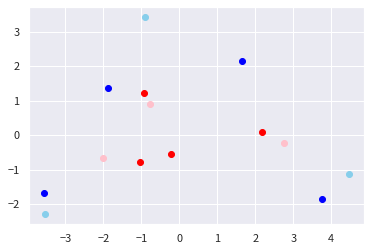

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

# WEAT with Word Embedding(W2Vec)

In [48]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [49]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


## Case 1

In [50]:
target_A = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_B = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_X = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_Y = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

1.4821917

## Case 2

### Case 2 with same word used at Case 1

In [51]:
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_Y = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

1.6929383

### Case 2 with different attribute set

In [52]:
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_Y = ['news', 'report', 'statement', 'broadcast', 'word']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

-0.08205083

# WEAT with self-made Word Embedding

## The flow of the experience

0. Word Embedding 추출할 자료 구하기
1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

In [53]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [54]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


In [179]:
tokenized[:5]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

In [197]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8902934193611145),
 ('다큐멘터리', 0.8511864542961121),
 ('드라마', 0.8160426020622253),
 ('영화로', 0.7974909543991089),
 ('코미디', 0.782855749130249),
 ('설정', 0.7815120816230774),
 ('형식', 0.7803974151611328),
 ('주제', 0.7726760506629944),
 ('스토리', 0.771087110042572),
 ('블랙유머', 0.7681456208229065)]

In [56]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [174]:
art[:100]

'사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로'

In [57]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [88]:
vectorizer_ex = TfidfVectorizer()
X = vectorizer_ex.fit_transform([art, gen])

print(X.shape)

print(vectorizer_ex.vocabulary_['영화'])
print(vectorizer_ex.get_feature_names()[23976])

(2, 41082)
23976
영화


In [89]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer_ex.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer_ex.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [60]:
X

<2x41082 sparse matrix of type '<class 'numpy.float64'>'
	with 56712 stored elements in Compressed Sparse Row format>

In [61]:
X[0]

<1x41082 sparse matrix of type '<class 'numpy.float64'>'
	with 18995 stored elements in Compressed Sparse Row format>

In [62]:
X[1]

<1x41082 sparse matrix of type '<class 'numpy.float64'>'
	with 37717 stored elements in Compressed Sparse Row format>

In [63]:
m1

<1x41082 sparse matrix of type '<class 'numpy.float64'>'
	with 18995 stored elements in COOrdinate format>

`X = vectorizer.fit_transform([art, gen])` -> 2차원의 벡터화된 sparse matrix를 생성한다.
`tocoo() ` -> sparse matrix의 압축 형태를 원래대로 풀어서 제공한다. 

In [86]:
len(vectorizer.get_feature_names())

33151

In [153]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer_ex.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer_ex.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(200):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(200):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

NotFittedError: Vocabulary not fitted or provided

In [92]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [80]:
type(model.wv)
print(model.wv)

여기에 추가로 w1와 w2 둘 다에 존재하는 단어를 모아본다. 

In [95]:
target_common = []
for i in range(100) :
    if (w1_[i] in w2_) : target_common.append(w1_[i])
print(target_common)

['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족', '이야기', '마을', '사건', '마음', '세상', '아버지', '아이', '엄마', '모든', '여자', '대한', '서로', '과연', '다시', '시간', '아들', '소녀', '아내', '다른', '사이', '영화제', '세계', '사실', '하나', '점점', '남편', '감독', '여행', '인생', '발견', '모두', '순간', '우리', '가장', '마지막', '생활', '모습', '통해', '죽음', '기억', '비밀', '학교', '한편', '소년', '생각', '도시', '명의', '사고', '결혼', '전쟁', '때문', '위기', '이제', '최고', '이자', '과거', '일상', '경찰', '상황', '간다', '미국', '현실', '관계', '단편', '하루', '인간', '국제', '살인', '동안', '존재', '어머니', '계속', '동생', '작품']


모든 장르에 존재하는 단어는 가중치를 더 낮게 주면 중복된 단어들이 줄어들지 않을까? IDF의 비중을 더 크게 만들자. 

In [107]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [68]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [109]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [110]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 30):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()


드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 가족, 단편, 대한, 아들, 아이, 마음, 서울, 남편, 서로, 시간, 소녀, 다른, 세상, 감독, 모든, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 관계, 부부, 아버지, 엄마, 점점, 사실, 영화, 시간, 다시, 사이, 다른, 회사, 아들, 생활, 유혹, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 한편, 아버지, 살인, 복수, 죽음, 아들, 남자, 임무, 범죄, 요원, 비밀, 납치, 다시, 마을, 상황, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 이야기, 인생, 아이, 아버지, 마음, 모든, 생각, 결혼, 서로, 다른, 생활, 엄마, 사실, 대한, 국제, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 미군, 목숨, 미국, 군인, 영국, 나치, 상황, 세계대전, 프랑스, 중위, 대원, 지역, 그녀, 이지중대, 혁리, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 사실, 소녀, 살인, 아이, 좀비, 정체, 비밀, 이야기, 여자, 영화제, 점점, 살해, 명의, 모든, 시간, 


In [71]:
# 매트릭스 초기화
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [72]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [73]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

멜로로맨스 액션 1.1135066
멜로로맨스 전쟁 1.4519087


<AxesSubplot:>

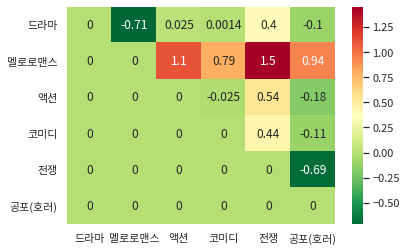

In [74]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [75]:
!ls ./aiffel/weat

GoogleNews-vectors-negative300.bin     synopsis_gen.txt
GoogleNews-vectors-negative300.bin.gz  synopsis_historical.txt
synopsis_action.txt		       synopsis_horror.txt
synopsis_adult.txt		       synopsis_musical.txt
synopsis_adventure.txt		       synopsis_mystery.txt
synopsis_animation.txt		       synopsis_romance.txt
synopsis_art.txt		       synopsis_SF.txt
synopsis_comedy.txt		       synopsis_show.txt
synopsis_crime.txt		       synopsis_thriller.txt
synopsis_documentary.txt	       synopsis.txt
synopsis_drama.txt		       synopsis_war.txt
synopsis_etc.txt		       synopsis_western.txt
synopsis_family.txt		       synopsis.zip
synopsis_fantasy.txt


tf-idf의 한계점은 BoW가 가지는 한계점과 같다. 단어의 벡터화는 단어의 의미를 담아내지 못한다. 그리고 단어장이 크면 클수록 tf-idf는 sparse 해질 수 밖에 없다. 그리고 해당 데이터는 각 장르의 대표 단어들을 뽑아야 하는데, 각 장르에서 유의미한 빈도로 출현한 단어라도 장르 전체를 보면 흔하게 등장하는 단어들이 많이 나오고 있기 때문에, attribute를 뽑되 중복된 단어들을 제거하고 모든 attribute set이 유의미한 길이가 될 때 까지 attribute set을 정제한다. 

1. 각 장르별 벡터를 만든다.
2. 전체 장르를 아우르는 벡터를 만든다. 
3. 전체 장르를 아우르는 벡터에서 상위 n개의 단어를 고른다. 
4. 각 장르별 벡터에서 attribute를 m개 뽑아낸다. 그 과정에서 3에서 추출한 단어들은 배제한다. 
5. weat score를 통해 편향성을 알아본다. 

In [112]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [123]:
print(len(genre_name))

21


In [113]:
del genre_all

In [114]:
genre_all = []
for file_name in genre_txt:
    genre_all.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [140]:
genre_total = []
genre_total = read_token("synopsis.txt")

synopsis.txt 파일을 읽고 있습니다.


KeyboardInterrupt: 

In [142]:
vectorizer_merge = TfidfVectorizer(sublinear_tf = True)
X_merge = vectorizer_merge.fit_transform(genre_all)

print(X_merge.shape)

(21, 42191)


`sublinear_tf = True` 옵션은 td값에 log를 취해 td의 영향력을 떨어뜨린다. 하도 중복되는 단어가 많아서 이 옵션을 주었다. 

In [143]:
'''
vectorizer_all = TfidfVectorizer(sublinear_tf = True)
X_all = vectorizer_all.fit_transform(genre_total)

print(X_all.shape)
'''

'\nvectorizer_all = TfidfVectorizer(sublinear_tf = True)\nX_all = vectorizer_all.fit_transform(genre_total)\n\nprint(X_all.shape)\n'

In [121]:
print(len(genre_all))

21


In [203]:
m_m = [X_merge[i].tocoo() for i in range(X_merge.shape[0])]

w_m = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m_m]

for i in range(len(w_m)):
    w_m[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w_m)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer_merge.get_feature_names()[w_m[i][j][0]] in model.wv:
            attr.append(vectorizer_merge.get_feature_names()[w_m[i][j][0]])
            #print(vectorizer_merge.get_feature_names()[w_m[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print(attr)

SF: ['켈빈', '분파', '컨트', '리플리', '영건', '미노스', '히노키', '수퍼맨', '위저드', '블랙옥스', '치티', '라임', '에일리언', '강두', '섹터']
가족: ['아주르', '씨제이', '슈이트', '마갈', '최호', '동구', '낙타', '벤트', '크누드', '누키', '펠리칸', '신차', '잉그릿', '제페토', '규완']
공연: ['리골레토', '토스카', '올레', '오텔로', '카르피', '비바', '만토바', '코락스', '베르디', '차이코프스키', '백작부인', '로돌포', '프로스페', '뱅쿠오', '레나토']
공포(호러): ['분홍신', '레스태트', '프롱삭', '아스왕', '부기맨', '악령', '누알', '패너', '사마귀', '에스터', '엘런', '데이나', '혜화', '머시', '빈젠트']
기타: ['완섭', '뉴미디어', '메트로', '에르나니', '포럼', '세르지뉴', '아도니스', '참프루', '페소아', '독도', '발달장애', '지서', '루하시', '초달', '송재']
다큐멘터리: ['다큐', '인디다큐페스티발', '라이머', '건축사', '지라니', '옥한흠', '김기덕', '퇴진', '세월호', '성소수자', '소록도', '석면', '코르뷔지', '페미니즘', '성노동자']
드라마: ['케코', '명주', '우민', '영남', '주기철', '재문', '치성', '포럼', '재경', '김산', '샤오윈', '톨부킨', '예준', '역도산', '정호']
멜로로맨스: ['원기', '완진', '준철', '지용', '미연', '석호', '구창', '호석', '대진', '윤재', '동욱', '혁수', '학규', '인혜', '조강']
뮤지컬: ['에스메랄다', '니웨', '페뷔스', '프롤', '제루샤', '샤오캉', '토스카', '카르피', '노트르담', '데이비', '모차르트', '카바', '캬바레', '프롤로', '살리에리']
미스터리: ['거미숲', '방독면', '랭던', '종섭',

In [152]:
print(len(attributes[10]))

200


In [159]:
# 매트릭스 초기화
matrix_all = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [211]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix_all[i][j] = weat_score(A, B, X, Y)
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_all[i][j] >= 1.1 or matrix_all[i][j] <= -1.1:
            print(genre_name[i], genre_name[j],matrix_all[i][j])

가족 기타 1.1660758
가족 애니메이션 1.158267
가족 전쟁 1.2175713
서부극(웨스턴) 전쟁 1.147461
어드벤처 전쟁 1.1512835


<AxesSubplot:>

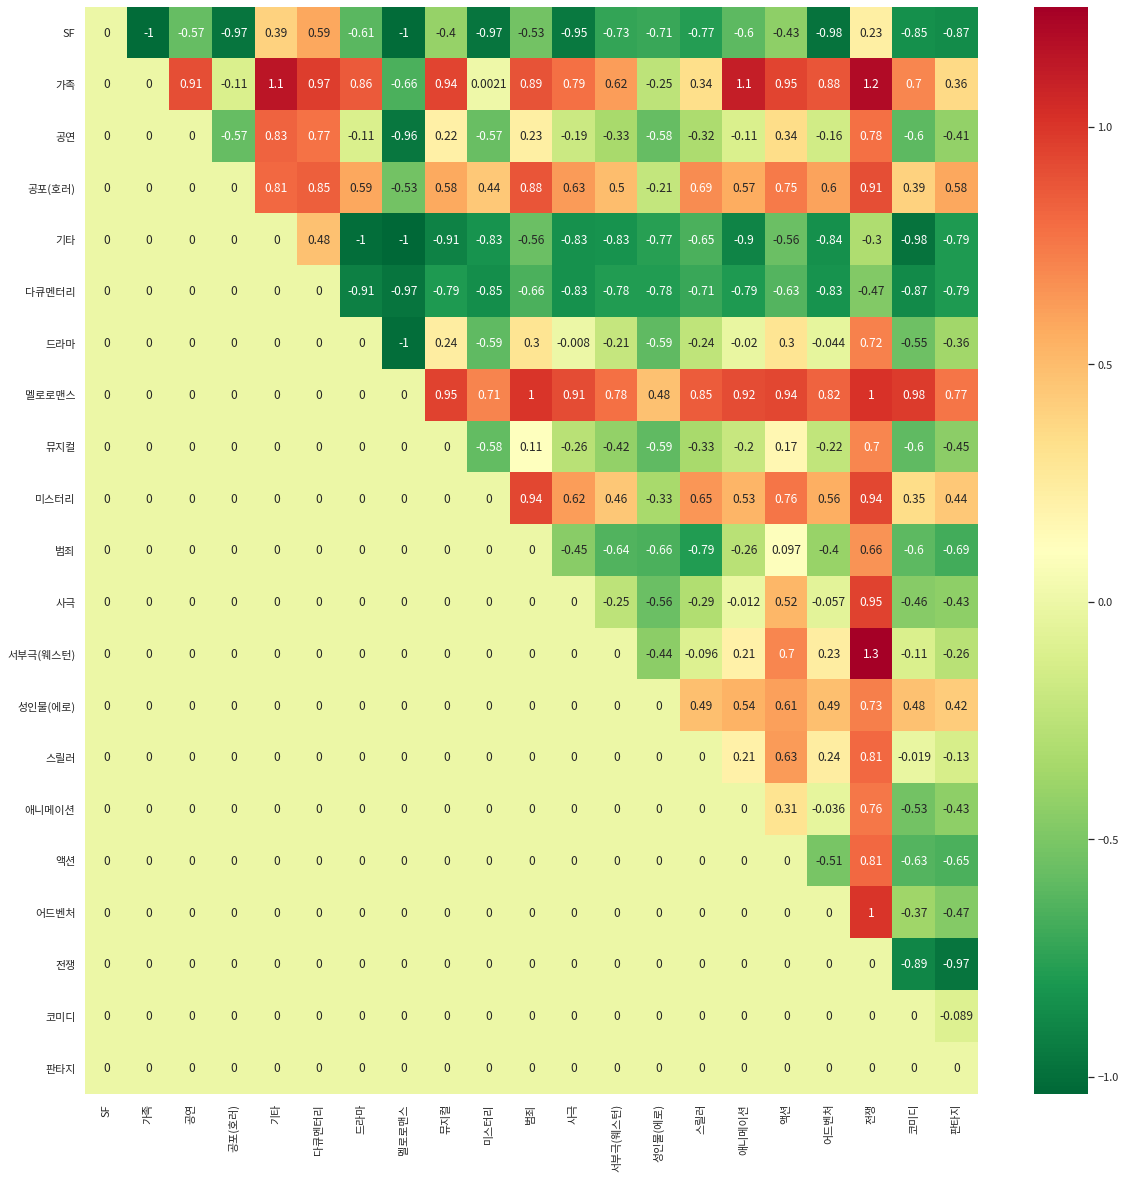

In [162]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix_all, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# 중복 제거
1. 전체 시놉시스를 tf-idf로 벡터화한다.
2. 전체에서 가장 비중이 높은 단어 n개를 고른다. n은 실험적으로 정해진다.
3. attribute 단어를 2를 제외한 단어로 구성한다. 
4. 다시 WEAT Score를 구한다. 
5. 앞전의 결과와 비교한다. 

In [166]:
print(len(tokenized))

71156


In [171]:
result = []
for i in tokenized :
    result += i
result[0]

'사운드'

In [180]:
# 전체 시놉시스에 대한 벡터화. 
vectorizer_all = TfidfVectorizer()
tokenized_join = ' '.join(result)
print(tokenized_join[:100])
X_all = vectorizer_all.fit_transform([tokenized_join])

사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로


In [181]:
X_all.shape

(1, 42820)

유의미하게 자주 등장하는 단어들을 40개 정도 뽑아낸다. 30개는 너무 보편적인 단어들이 많이 나왔고 50개부터는 고유명사들이 나오기 시작해서 40개로 정했다. 

In [193]:
m_a = [X_all[i].tocoo() for i in range(X_all.shape[0])]

w_a = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m_a]

for i in range(len(w_a)):
    w_a[i].sort(key=lambda x: x[1], reverse=True)
attributes_a = []
for i in range(len(w_a)):
    attr = []
    j = 0
    while (len(attr) < 40):
        if vectorizer_merge.get_feature_names()[w_a[i][j][0]] in model.wv:
            attr.append(vectorizer_all.get_feature_names()[w_a[i][j][0]])
            #print(vectorizer_merge.get_feature_names()[w_m[i][j][0]], end=', ')
        j += 1
    attributes_a.append(attr)
attributes_a = attributes_a[0]
print(attributes_a)

['자신', '위해', '시작', '사람', '사랑', '영화', '남자', '여자', '사건', '서울', '가족', '아버지', '남편', '엄마', '다른', '모든', '아들', '세상', '사실', '세계', '소녀', '통해', '아내', '발견', '작품', '관계', '과연', '점점', '생활', '애니메이션', '한편', '여성', '가장', '여행', '소년', '인간', '순간', '명의', '간다', '이제']


attribute를 정할때 위의 단어들이 등장하지 않도록 코드를 수정했다. 

In [204]:
m_m = [X_merge[i].tocoo() for i in range(X_merge.shape[0])]

w_m = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m_m]

for i in range(len(w_m)):
    w_m[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w_m)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    att_candi = vectorizer_merge.get_feature_names()[w_m[i][j][0]] 
    while (len(attr) < 15):
        if vectorizer_merge.get_feature_names()[w_m[i][j][0]] in model.wv and vectorizer_merge.get_feature_names()[w_m[i][j][0]] not in attributes_a :
            attr.append(vectorizer_merge.get_feature_names()[w_m[i][j][0]])
            #print(vectorizer_merge.get_feature_names()[w_m[i][j][0]], end=', ')
        j += 1
    print(attr)
    attributes.append(attr)

SF: ['켈빈', '분파', '컨트', '리플리', '영건', '미노스', '히노키', '수퍼맨', '위저드', '블랙옥스', '치티', '라임', '에일리언', '강두', '섹터']
가족: ['아주르', '씨제이', '슈이트', '마갈', '최호', '동구', '낙타', '벤트', '크누드', '누키', '펠리칸', '신차', '잉그릿', '제페토', '규완']
공연: ['리골레토', '토스카', '올레', '오텔로', '카르피', '비바', '만토바', '코락스', '베르디', '차이코프스키', '백작부인', '로돌포', '프로스페', '뱅쿠오', '레나토']
공포(호러): ['분홍신', '레스태트', '프롱삭', '아스왕', '부기맨', '악령', '누알', '패너', '사마귀', '에스터', '엘런', '데이나', '혜화', '머시', '빈젠트']
기타: ['완섭', '뉴미디어', '메트로', '에르나니', '포럼', '세르지뉴', '아도니스', '참프루', '페소아', '독도', '발달장애', '지서', '루하시', '초달', '송재']
다큐멘터리: ['다큐', '인디다큐페스티발', '라이머', '건축사', '지라니', '옥한흠', '김기덕', '퇴진', '세월호', '성소수자', '소록도', '석면', '코르뷔지', '페미니즘', '성노동자']
드라마: ['케코', '명주', '우민', '영남', '주기철', '재문', '치성', '포럼', '재경', '김산', '샤오윈', '톨부킨', '예준', '역도산', '정호']
멜로로맨스: ['원기', '완진', '준철', '지용', '미연', '석호', '구창', '호석', '대진', '윤재', '동욱', '혁수', '학규', '인혜', '조강']
뮤지컬: ['에스메랄다', '니웨', '페뷔스', '프롤', '제루샤', '샤오캉', '토스카', '카르피', '노트르담', '데이비', '모차르트', '카바', '캬바레', '프롤로', '살리에리']
미스터리: ['거미숲', '방독면', '랭던', '종섭',

In [205]:
# 매트릭스 초기화
matrix_all_2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [210]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix_all_2[i][j] = weat_score(A, B, X, Y)
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_all_2[i][j] >= 1.1 or matrix_all_2[i][j] <= -1.1:
            print(genre_name[i], genre_name[j],matrix_all_2[i][j])

가족 기타 1.1657752
가족 애니메이션 1.1475528
가족 전쟁 1.211782
서부극(웨스턴) 전쟁 1.1441085
어드벤처 전쟁 1.1512452


유의미한 변화가 있는지 살펴보기 위해 weat score에 변화가 일어난 장르들을 쭉 출력해보았다. 결과값을 볼 때, 대체로 편향성이 증가하는 방향으로 weat score가 계산되었다. 양이면 양의 방향, 음이면 음의 방향으로. 이전에 1.1 혹은 -1.1 밖의 편향성 점수를 가진 장르들은 이번에도 같이 나왔다. 
```
가족 기타 1.1657752
가족 애니메이션 1.1475528
가족 전쟁 1.211782
서부극(웨스턴) 전쟁 1.1441085
어드벤처 전쟁 1.1512452
```

In [213]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_all[i][j] != matrix_all_2[i][j] : 
            print(genre_name[i], genre_name[j], matrix_all[i][j], matrix_all_2[i][j], abs(matrix_all[i][j]-matrix_all_2[i][j]))
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_all_2[i][j] >= 1.1 or matrix_all_2[i][j] <= -1.1:
            print(genre_name[i], genre_name[j],matrix_all_2[i][j])
        if matrix_all_2[i][j] >= 1.1 or matrix_all_2[i][j] <= -1.1:
            print(genre_name[i], genre_name[j],matrix_all_2[i][j])

SF 가족 -0.8834823 -0.8840882 0.0006059408
SF 공연 -0.4144747 -0.4571188 0.042644113
SF 공포(호러) -0.92405903 -0.9217675 0.0022915602
SF 기타 0.5017077 0.5134249 0.0117172
SF 다큐멘터리 0.62476337 0.6391554 0.014392018
SF 드라마 -0.41384968 -0.459334 0.045484304
SF 멜로로맨스 -0.95346826 -0.9757127 0.022244453
SF 뮤지컬 -0.26605654 -0.2922954 0.026238859
SF 미스터리 -0.89357466 -0.90630174 0.012727082
SF 범죄 -0.41484317 -0.47853693 0.06369376
SF 사극 -0.5143146 -0.56434035 0.05002576
SF 서부극(웨스턴) -0.49119377 -0.5097335 0.018539727
SF 성인물(에로) -0.6483607 -0.6804018 0.032041073
SF 스릴러 -0.7349672 -0.7686405 0.033673346
SF 애니메이션 -0.41924223 -0.40679204 0.012450188
SF 액션 -0.15930797 -0.21217117 0.052863196
SF 어드벤처 -0.6110403 -0.60968584 0.001354456
SF 전쟁 0.42398122 0.4282016 0.0042203665
SF 코미디 -0.54919064 -0.59143806 0.042247415
SF 판타지 -0.73618615 -0.706361 0.029825151
가족 공연 0.8790225 0.8224366 0.056585908
가족 공포(호러) -0.15088806 -0.1656733 0.014785245
가족 기타 1.1660758 1.1657752 0.00030064583
가족 다큐멘터리 0.97161084 0.9767648 0.0

결과에 대해 시각화해보았다. 

<AxesSubplot:>

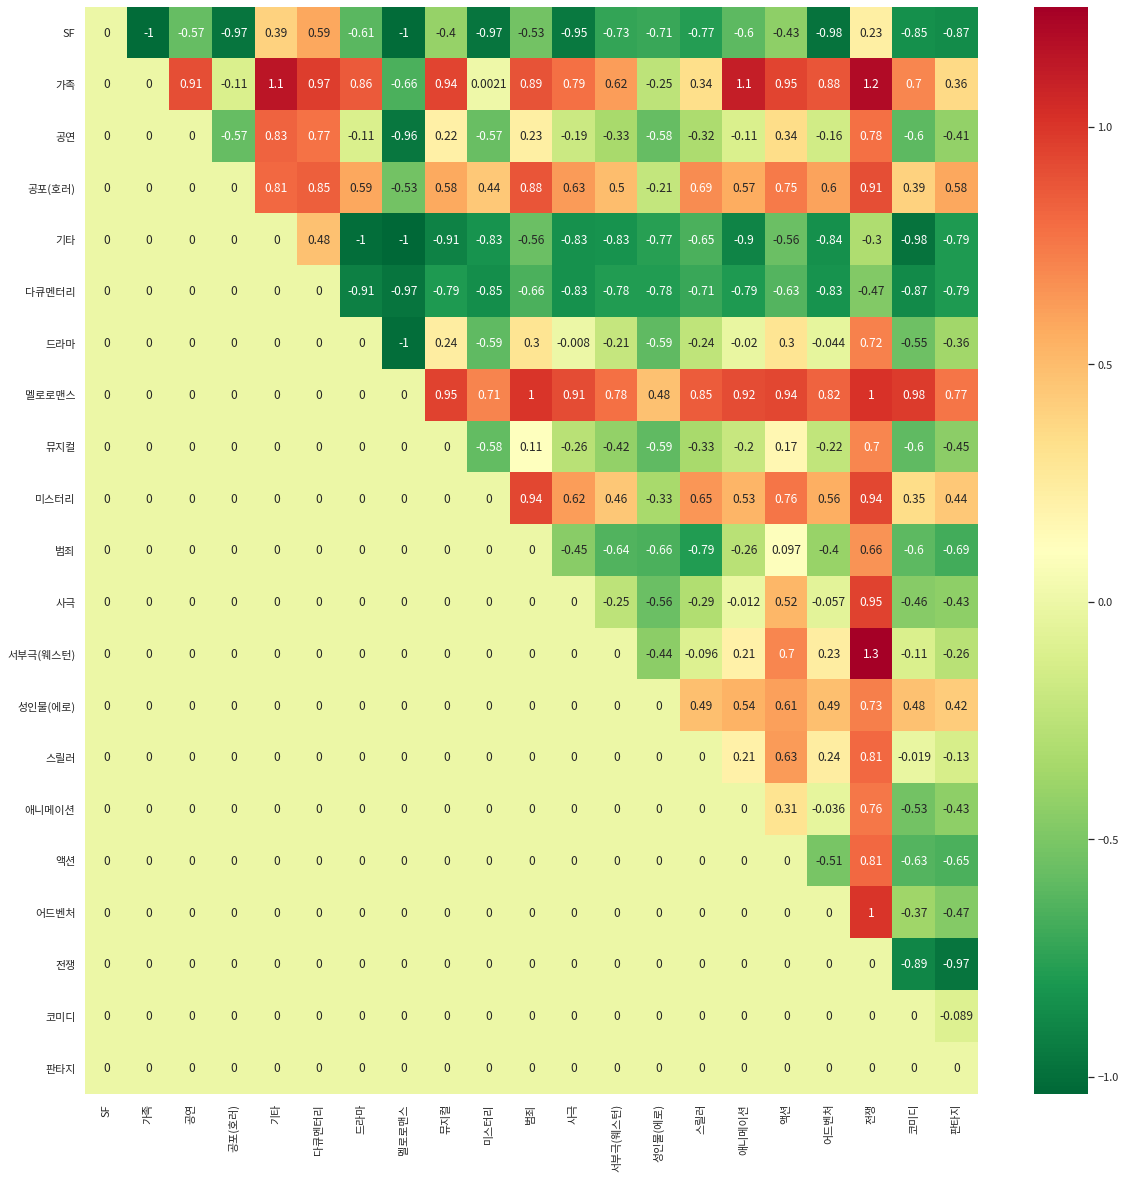

In [209]:
ax = sns.heatmap(matrix_all, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

<AxesSubplot:>

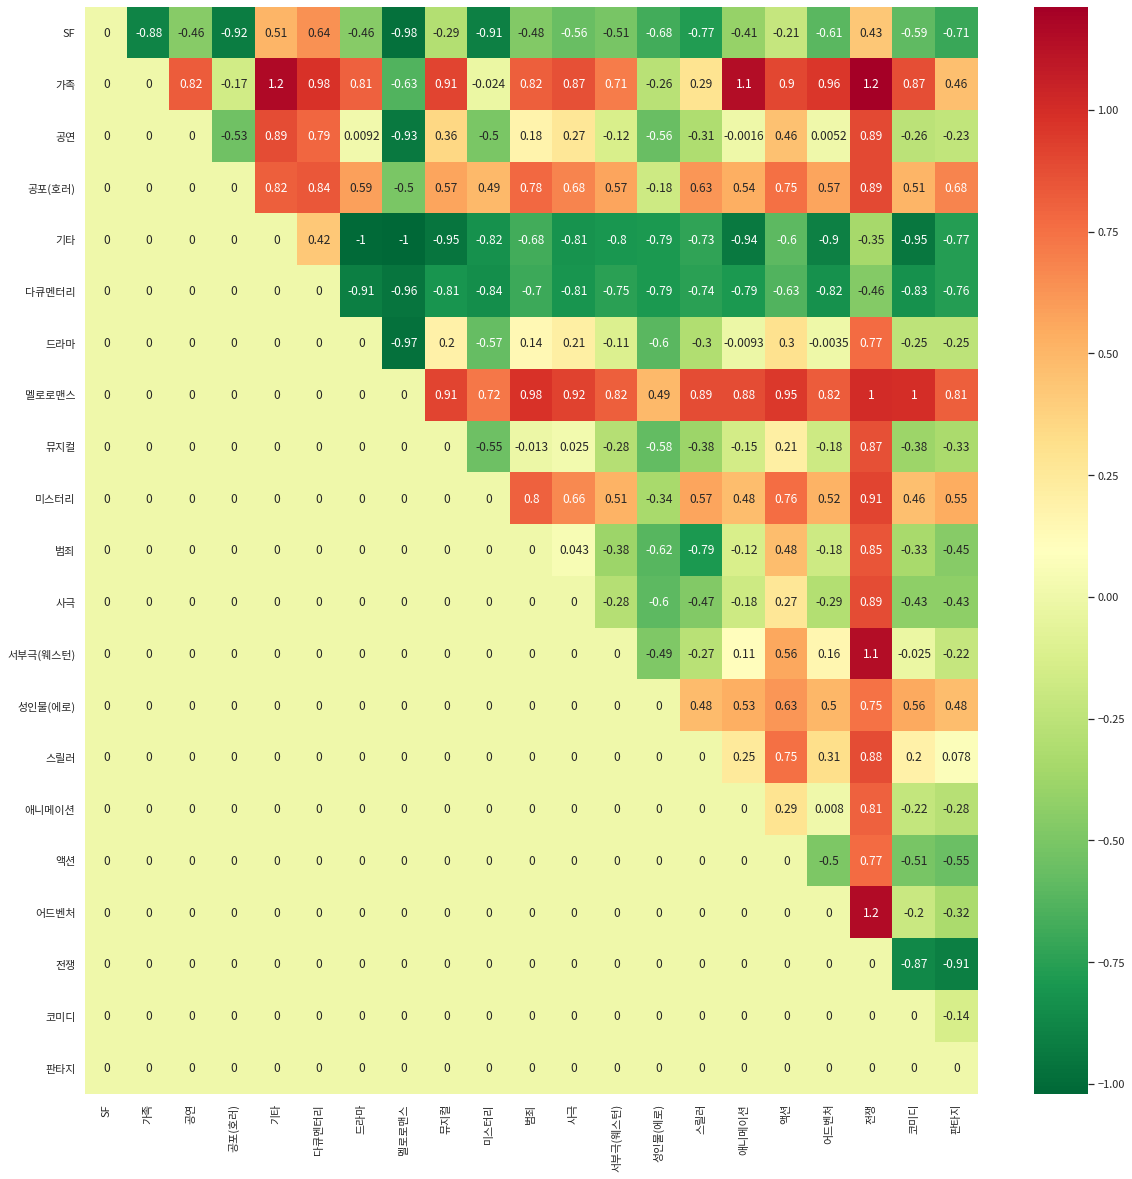

In [208]:
ax2 = sns.heatmap(matrix_all_2, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax2

# Reference
1. tf-idf 설명 글 : https://thinkwarelab.wordpress.com/2016/11/14/ir-tf-idf-%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B4%85%EC%8B%9C%EB%8B%A4/#:~:text=%EB%AC%B8%EC%84%9C%EC%97%90%20%EB%8B%A8%EC%96%B4%EA%B0%80%20%EB%82%98%ED%83%80%EB%82%98%EB%A9%B4,%EA%B2%BD%EC%9A%B0%EC%97%90%20%EC%82%AC%EC%9A%A9%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.
